# Overpass queries

We use the Overpass API to grab the location of restaurants, bars, etc in a given list of countries.

We could input the list manually, but we can also define the limits of the map and start by asking Overpass to tell us which countries are inside this box.

In [1]:
import requests

In [22]:
#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = """[out:json];
rel[boundary=administrative][admin_level=2](28,-26,67,160);
out center;"""

print(overpass_query)

response = requests.get(overpass_url, params={'data': overpass_query})
list_of_countries = response.json()

[out:json];
rel[boundary=administrative][admin_level=2](28,-26,67,160);
out center;


In [71]:
all_countries = [ list_of_countries['elements'][iii]['tags']['name:en'] for iii in range(len(list_of_countries['elements'])) ]
# if the name contains a dash OR a hyphen (not the same character!)
# then it encodes a border, we only need countries
all_countries = [ccc for ccc in all_countries if ('-' in ccc) == False ]
all_countries = [ccc for ccc in all_countries if ('—' in ccc) == False ]

We define functions that write the query for us, and a function that turns the json output into a pandas dataframe.

In [65]:
import pandas as pd

def query_amenity_country(typeOfAmenity,countryName,printQuery=False):
    #get data from OSM using Overpass API
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json];
    area["name:en"="%s"][admin_level=2]->.searchArea;

    (node["amenity"="%s"](area.searchArea); 
    way["amenity"="%s"](area.searchArea);
    rel["amenity"="%s"](area.searchArea);
    node["shop"="%s"](area.searchArea); 
    way["shop"="%s"](area.searchArea);
    rel["shop"="%s"](area.searchArea);
    );
    out center;
    """ % tuple([countryName]+6*[typeOfAmenity])
    if printQuery:
        print(overpass_query)
    response = requests.get(overpass_url, params={'data': overpass_query})
    return response.json()

def query_amenity_country_long(typeOfAmenity,countryName,printQuery=False):
    #get data from OSM using Overpass API
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json][timeout:600];
    area["name:en"="%s"][admin_level=2]->.searchArea;

    (node["amenity"="%s"](area.searchArea); 
    way["amenity"="%s"](area.searchArea);
    rel["amenity"="%s"](area.searchArea);
    );
    out center;
    """ % tuple([countryName]+3*[typeOfAmenity])
    if printQuery:
        print(overpass_query)
    response = requests.get(overpass_url, params={'data': overpass_query})
    return response.json()


def json_to_pd(someJson):
    #convert json into dataframe
    df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "shop":[], "amenity":[]}

    for element in someJson['elements']:
        df_dict["id"].append(element["id"])
        df_dict["type"].append(element["type"])

        for tag in ["name", "shop", "amenity"]:
            try:
                df_dict[tag].append(element["tags"][tag])
            except KeyError:
                df_dict[tag].append("") 
        if element["type"]=="node":
            df_dict["lat"].append(element["lat"])
            df_dict["lon"].append(element["lon"])
        else:
            df_dict["lat"].append(element["center"]["lat"])
            df_dict["lon"].append(element["center"]["lon"])

    return pd.DataFrame.from_dict(df_dict)

I also use `clear_output` to print the country currently queried without clogging up the screen.

In the following loop I save the data to a file, so I can later work on the plotting without having to query again.

In [5]:
from IPython.display import clear_output
import time

In [69]:
def full_loop(amenity):
    all_dfs = []
    startTime = time.time()

    for iii,countryName in enumerate(all_countries):
        clear_output(wait=True)
        print(countryName,iii,'/',len(all_countries),int(time.time()-startTime),'   seconds')
        if amenity=='restaurant' and countryName=='Russia':
            iii_country = query_amenity_country_long(amenity,countryName,printQuery=False)            
        else:
            iii_country = query_amenity_country(amenity,countryName,printQuery=False)
        ddd_country = json_to_pd(iii_country)
        ddd_country['country'] = countryName
        all_dfs.append( ddd_country )
        
    cdf = pd.concat( all_dfs )
    cdf.to_csv('all_%s.csv' % (amenity),index=False)
    return cdf

In [25]:
%%time
full_loop('pub')

Morocco 84 / 85 390    seconds
CPU times: user 3.46 s, sys: 432 ms, total: 3.89 s
Wall time: 6min 34s


,id,type,lat,lon,name,shop,amenity,country
0,6.907346e+08,node,42.540867,1.731753,Kyu,,pub,Andorra
1,6.907346e+08,node,42.541152,1.731658,Havana Club,,pub,Andorra
2,6.907347e+08,node,42.541084,1.731684,Mulligan's,,pub,Andorra
3,3.817290e+09,node,42.509330,1.535807,The Camden - English Pub,,pub,Andorra
4,4.010670e+09,node,42.576972,1.666813,Aspen,,pub,Andorra
...,...,...,...,...,...,...,...,...
26,1.014885e+09,way,33.898751,-5.545779,Montana,,pub,Morocco
27,1.109768e+09,way,35.241045,-3.928360,Cafe Villa Florido,,pub,Morocco
28,1.116635e+09,way,35.128175,-3.844686,,,pub,Morocco
29,1.135987e+09,way,34.258331,-6.586930,,,pub,Morocco


In [26]:
%%time
full_loop('bar')

Morocco 84 / 85 359    seconds
CPU times: user 3.2 s, sys: 372 ms, total: 3.58 s
Wall time: 6min 4s


,id,type,lat,lon,name,shop,amenity,country
0,5.211464e+08,node,42.569504,1.489257,Red X,,bar,Andorra
1,5.227880e+08,node,42.577872,1.480165,,,bar,Andorra
2,5.938706e+08,node,42.573433,1.483100,Bar/Restaurant 360,,bar,Andorra
3,5.938706e+08,node,42.572117,1.483700,Black Bull Bar,,bar,Andorra
4,5.938706e+08,node,42.573235,1.483389,Cau Bar,,bar,Andorra
...,...,...,...,...,...,...,...,...
246,1.228460e+09,way,33.241814,-8.487827,Bar Marrakech,,bar,Morocco
247,1.228460e+09,way,33.242523,-8.487743,Bar El Khaima,,bar,Morocco
248,1.238839e+09,way,33.251692,-8.502698,,,bar,Morocco
249,1.238839e+09,way,33.252053,-8.502873,Les Négociants,,bar,Morocco


In [27]:
%%time
full_loop('ice_cream')

Morocco 84 / 85 265    seconds
CPU times: user 1.77 s, sys: 259 ms, total: 2.03 s
Wall time: 4min 27s


,id,type,lat,lon,name,shop,amenity,country
0,4.171467e+08,node,48.142602,17.109235,Arthur,,ice_cream,Slovakia
1,4.324813e+08,node,48.706858,21.244163,,ice_cream,ice_cream,Slovakia
2,4.417211e+08,node,48.379774,18.221298,U Beďa,,ice_cream,Slovakia
3,4.631655e+08,node,48.141426,17.106565,Luculus,,ice_cream,Slovakia
4,8.077948e+08,node,48.310457,18.108251,Zmrzlina Mimóza,,ice_cream,Slovakia
...,...,...,...,...,...,...,...,...
22,1.011982e+10,node,30.401517,-9.584848,Oliveri,,ice_cream,Morocco
23,1.114867e+10,node,35.777882,-5.810427,Maison Glaces,,ice_cream,Morocco
24,1.123099e+10,node,31.511938,-9.771931,,,ice_cream,Morocco
25,1.128074e+10,node,35.570290,-5.375116,Rimal Gelato,,ice_cream,Morocco


In [70]:
%%time
full_loop('restaurant')

Morocco 84 / 85 1544    seconds
CPU times: user 12.7 s, sys: 1.39 s, total: 14.1 s
Wall time: 25min 58s


,id,type,lat,lon,name,shop,amenity,country
0,321679777,node,42.435343,1.520720,la Rabassa,,restaurant,Andorra
1,521134858,node,42.572508,1.483202,Surf,,restaurant,Andorra
2,522787948,node,42.578187,1.479702,Pampa,,restaurant,Andorra
3,593870539,node,42.573350,1.470650,Restaurant Panoramix,,restaurant,Andorra
4,593870549,node,42.569658,1.488014,Bar El Bosc,,restaurant,Andorra
...,...,...,...,...,...,...,...,...
3443,1238965374,way,33.254743,-8.500647,Pesca,,restaurant,Morocco
3444,1238965376,way,33.255192,-8.500288,Port,,restaurant,Morocco
3445,1238965396,way,33.253495,-8.501374,Ex Quick,,restaurant,Morocco
3446,7568967,relation,30.467715,-8.883816,Riad dar Dzahra,,restaurant,Morocco


In [29]:
%%time
ff = full_loop('fast_food')
# for some reason (Japanese characters?) some rows end up written wrong
# we remove rows where making the longitude a float raises an error:
ff = pd.read_csv('all_fast_food.csv')
ff = ff[pd.to_numeric(ff['lon'], errors='coerce').notnull()]
ff.to_csv('all_fast_food.csv',index=False)

Morocco 84 / 85 456    seconds
CPU times: user 5.69 s, sys: 612 ms, total: 6.3 s
Wall time: 7min 40s


,id,type,lat,lon,name,shop,amenity,country
0,5.211356e+08,node,42.572241,1.483661,,,fast_food,Andorra
1,6.667936e+08,node,42.554741,1.616403,,,fast_food,Andorra
2,6.667936e+08,node,42.542532,1.660608,,,fast_food,Andorra
3,6.667936e+08,node,42.567690,1.641328,,,fast_food,Andorra
4,6.667936e+08,node,42.564705,1.663022,,,fast_food,Andorra
...,...,...,...,...,...,...,...,...
921,1.228612e+09,way,33.239855,-8.496682,Burger King,,fast_food,Morocco
922,1.228905e+09,way,33.228501,-8.504595,,,fast_food,Morocco
923,1.238839e+09,way,33.251758,-8.502703,Tropical,,fast_food,Morocco
924,1.239468e+09,way,33.245703,-8.504748,,,fast_food,Morocco


In [30]:
%%time
full_loop('cafe')

Morocco 84 / 85 416    seconds
CPU times: user 6.61 s, sys: 699 ms, total: 7.31 s
Wall time: 7min


,id,type,lat,lon,name,shop,amenity,country
0,690737595,node,42.541347,1.731701,Cibercafé,,cafe,Andorra
1,1894424004,node,42.526112,1.687775,,,cafe,Andorra
2,1934464761,node,42.533320,1.579380,Ganja Bar Valira,,cafe,Andorra
3,2430772672,node,42.507618,1.531636,Granja,,cafe,Andorra
4,2966686810,node,42.546425,1.514765,Cafe BonDia,,cafe,Andorra
...,...,...,...,...,...,...,...,...
5356,1238708803,way,31.628859,-8.257822,Cafe Nakhil Loudaya,,cafe,Morocco
5357,1238838587,way,33.250991,-8.503216,Tout Va Bien,,cafe,Morocco
5358,1238900531,way,33.252311,-8.503512,Zahwa,,cafe,Morocco
5359,1244017060,way,35.153545,-3.002015,Cafe Toscana,,cafe,Morocco


# Combine heatmaps into a RGB image



In [18]:
import pandas as pd
food_files = ['all_'+a+'.csv' for a in 'fast_food,restaurant,ice_cream,cafe'.split(',')]
df_food = pd.concat([pd.read_csv(f) for f in food_files], ignore_index=True)

drink_files = ['all_'+a+'.csv' for a in 'bar,pub'.split(',')]
df_drink = pd.concat([pd.read_csv(f) for f in drink_files], ignore_index=True)

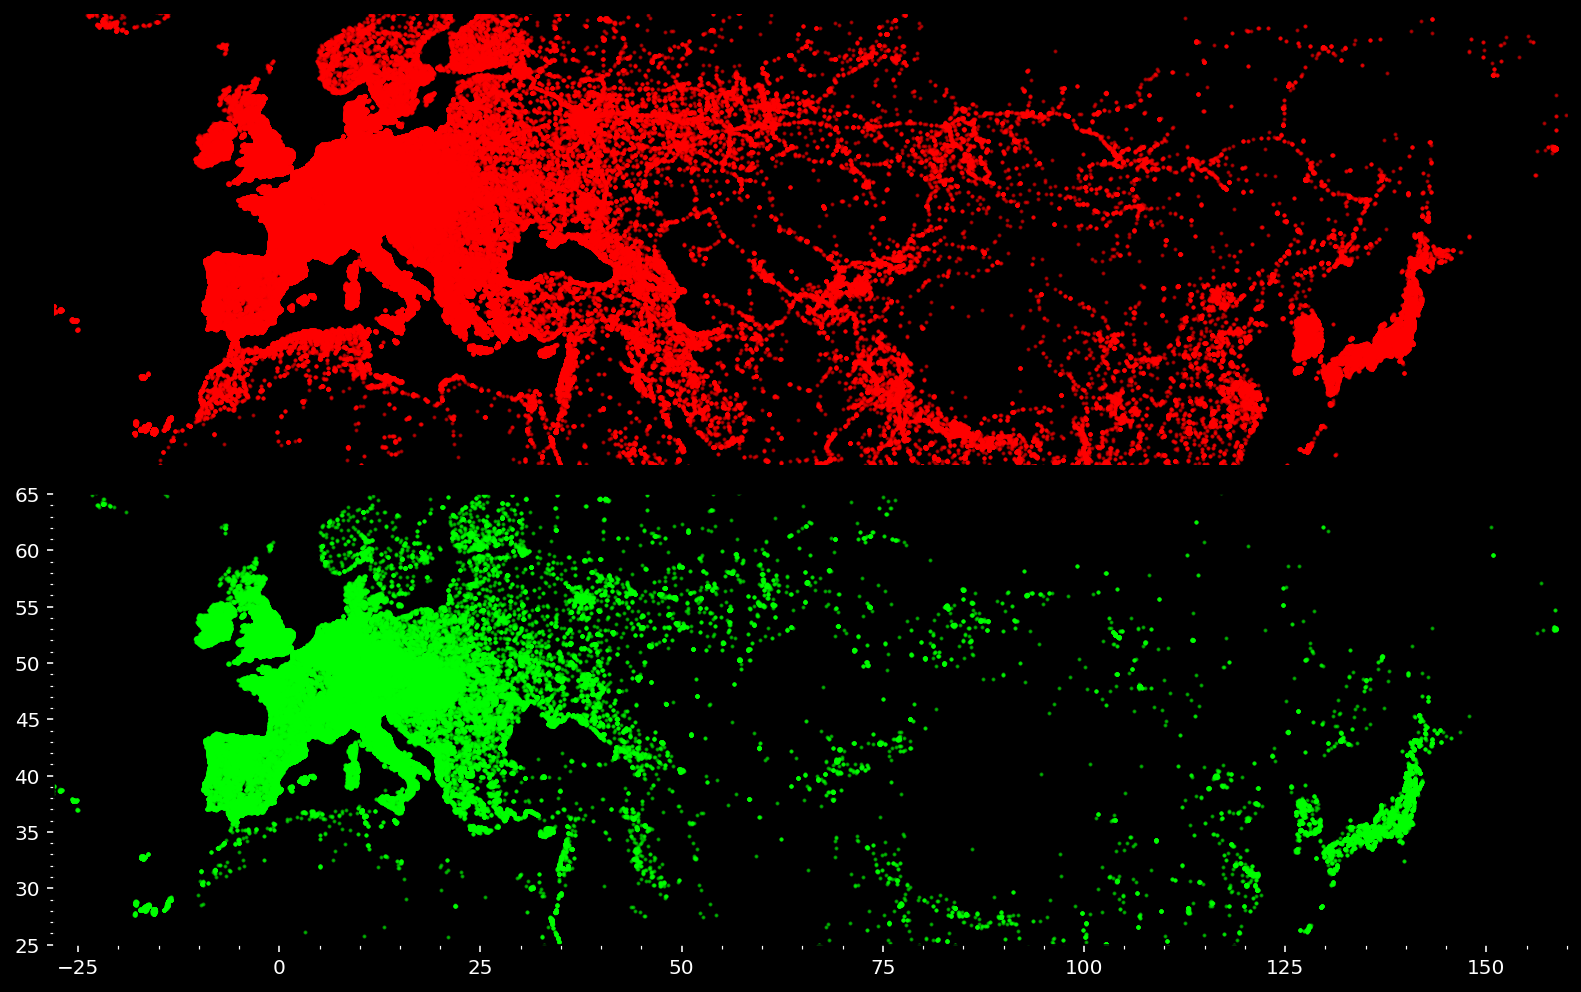

In [19]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.figure(figsize=(12,7),facecolor='k')

plt.subplot(211,aspect=1.4,facecolor='k')
plt.scatter(df_food['lon'],df_food['lat'],s=1,c='red',alpha=0.5)
plt.xlim(-28,160)
plt.ylim(25,65)
plt.axis('off')

plt.subplot(212,aspect=1.4,facecolor='k')
plt.scatter(df_drink['lon'],df_drink['lat'],s=1,c='lime',alpha=0.5)
plt.xlim(-28,160)
plt.ylim(25,65)
ax = plt.gca()
#ax.spines['bottom'].set_color('#ffffff')
#ax.spines['bottom'].set_color('#ffffff')

ax.tick_params(axis='x', colors='white',which='both')
ax.tick_params(axis='y', colors='white',which='both')

plt.minorticks_on()
plt.tight_layout()

# RGB with continuous values

CPU times: user 17.9 s, sys: 294 ms, total: 18.2 s
Wall time: 17.9 s


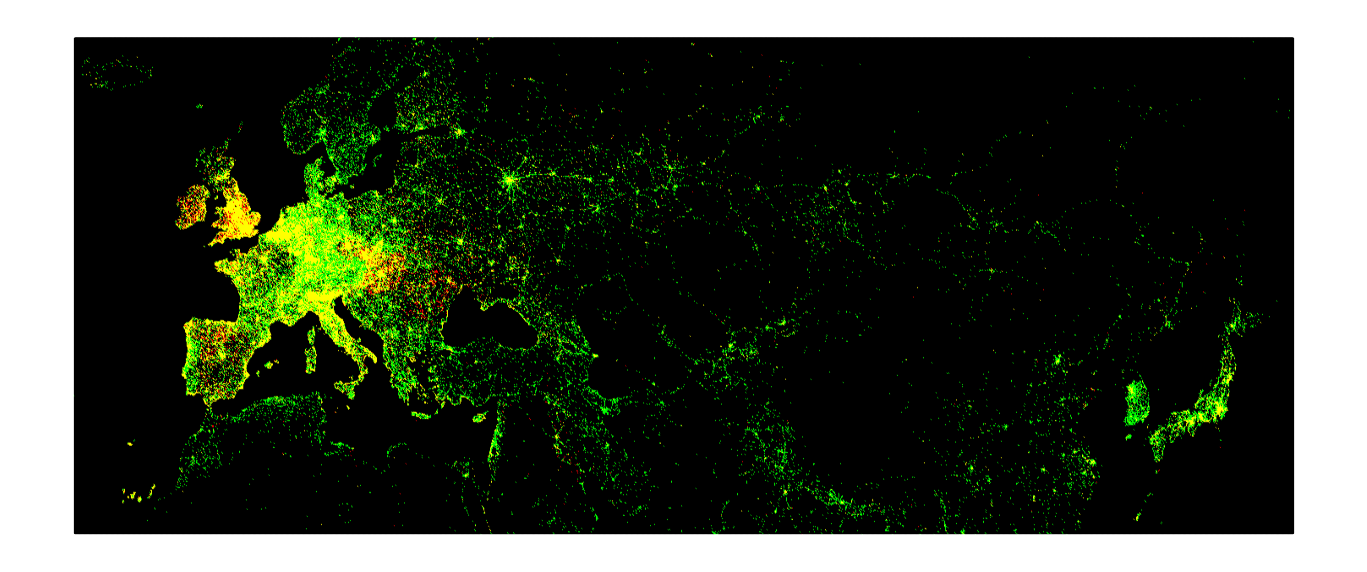

In [22]:
%%time
mmm = 4
grid_size = (360*mmm,120*mmm)


plt.figure(figsize=(12,5))
plt.subplot(111,aspect=1.3)

h_food = plt.hexbin( df_food['lon'],df_food['lat'] , extent=(-25,150,25,68), bins='log',
          gridsize=grid_size)
new_counts_food = np.array( h_food.get_array() )
new_counts_food[ new_counts_food==1 ] = 0.
new_counts_food[ new_counts_food==2 ] = 0.99
new_counts_food[ new_counts_food>2 ] = 1.
plt.clf() # we remove this one, we will create another one for drinks and update its colours based on both


h_drink = plt.hexbin( df_drink['lon'],df_drink['lat'] , extent=(-25,150,25,68), bins='log',
          gridsize=grid_size)
new_counts_drink = np.array( h_drink.get_array() )
new_counts_drink[ new_counts_drink==1 ] = 0.
new_counts_drink[ new_counts_drink==2 ] = 0.99
new_counts_drink[ new_counts_drink>2 ] = 1.


red_array = np.array([[ddd,fff,0.,1.] for fff,ddd in zip(new_counts_food,new_counts_drink) ])

ax = plt.gca()
ax.figure.canvas.draw()
h_drink.set(array=None, facecolors=red_array)
plt.axis('off')

plt.savefig('food_vs_drink.png',dpi=300)

# Discrete assignment

CPU times: user 18.4 s, sys: 267 ms, total: 18.6 s
Wall time: 18.4 s


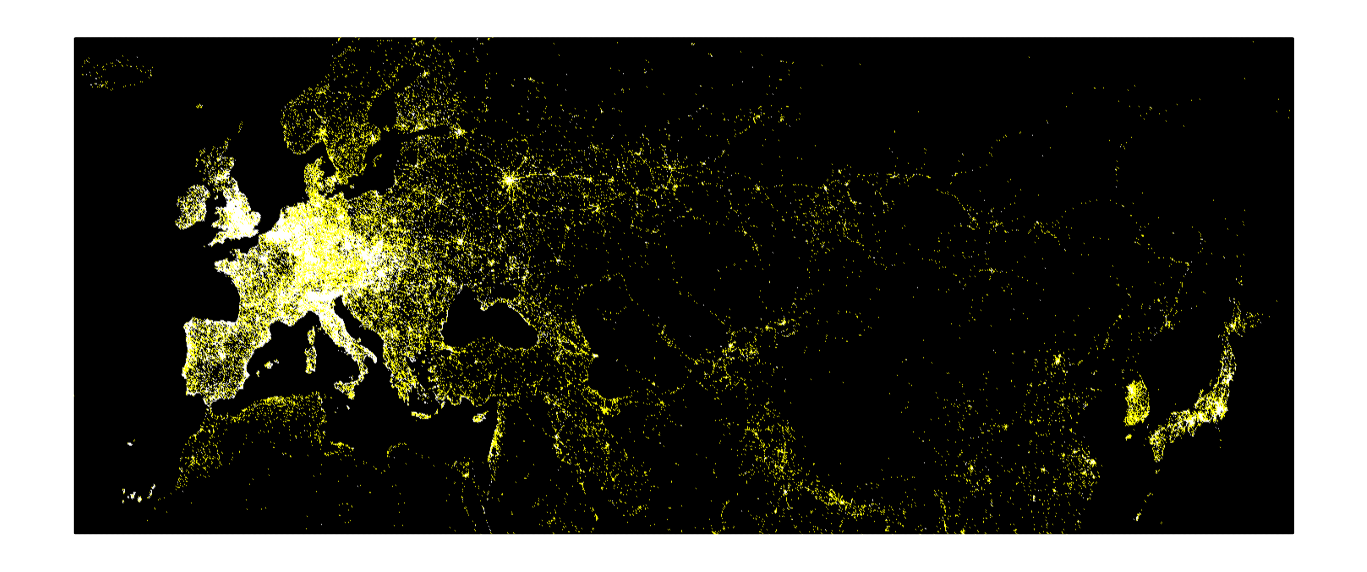

In [17]:
%%time
mmm = 4
grid_size = (360*mmm,120*mmm)


plt.figure(figsize=(12,5))
plt.subplot(111,aspect=1.3)

h_food = plt.hexbin( df_food['lon'],df_food['lat'] , extent=(-25,150,25,68), bins='log',
          gridsize=grid_size)
counts_food = np.array( h_food.get_array() )
plt.clf() # we remove this one, we will create another one for drinks and update its colours based on both


h_drink = plt.hexbin( df_drink['lon'],df_drink['lat'] , extent=(-25,150,25,68), bins='log',
          gridsize=grid_size)
counts_drink = np.array( h_drink.get_array() )

# all black, then if >1 food: if >1 drink set to white, else to yellow (food only)
#                 else: if >1 drink set to cyan
colour_array = np.array([[0.,0.,0.,1.] for foo in counts_drink])
for iii in range(len(counts_drink)):
    if counts_food[iii]>1:
        if counts_drink[iii]>1:
            colour_array[iii]=[1.,1.,1.,1.]
        else:
            colour_array[iii]=[1.,1.,0.,1.]
    elif counts_drink[iii]>1:
        colour_array[iii]=[1.,1.,0.,1.]
            
            
ax = plt.gca()
ax.figure.canvas.draw()
h_drink.set(array=None, facecolors=colour_array)
plt.axis('off')

plt.savefig('food_vs_drink_two.png',dpi=300)